In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset (hard-coded as required)
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4], dtype=float)
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200], dtype=float)
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0], dtype=float)

m = M.size
m

10

## 1) Dataset visualization (mandatory)
Plot $L$ vs $M$ and encode $T$ with color (hotter stars shown differently).

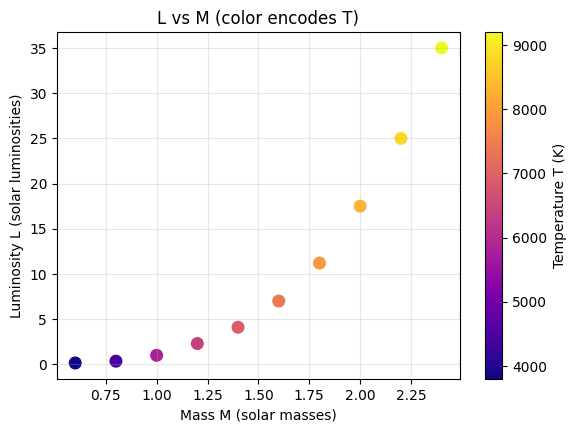

In [41]:
plt.figure(figsize=(6.5,4.5))
sc = plt.scatter(M, L, c=T, cmap='plasma', s=70)
plt.colorbar(sc, label='Temperature T (K)')
plt.xlabel('Mass M (solar masses)')
plt.ylabel('Luminosity L (solar luminosities)')
plt.title('L vs M (color encodes T)')
plt.grid(True, alpha=0.3)
plt.show()

## 2) Feature engineering (mandatory)
We build the design matrix with NumPy vectorization (no loops):
- $M$
- $T$
- $M^2$
- $M\cdot T$

Note: because $T$ is in the thousands, we standardize feature columns (mean 0, std 1) to make gradient descent stable. This is just NumPy arithmetic (still from scratch).

In [42]:
def make_X(M, T, model='M3'):
    if model == 'M1':
        X = np.column_stack([M, T])
    elif model == 'M2':
        X = np.column_stack([M, T, M**2])
    elif model == 'M3':
        X = np.column_stack([M, T, M**2, M*T])
    else:
        raise ValueError('model must be M1, M2, or M3')
    return X.astype(float)

def standardize_fit_transform(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma = np.where(sigma == 0, 1.0, sigma)
    Xn = (X - mu) / sigma
    return Xn, mu, sigma

def standardize_transform(X, mu, sigma):
    return (X - mu) / sigma

## 3) Loss and gradients (vectorized) (mandatory)
We use the same cost form:
$$J(\mathbf{w},b) = \frac{1}{2m}\sum_{i=1}^m(\hat{L}^{(i)}-L^{(i)})^2$$
Vectorized gradients:
$$\nabla_\mathbf{w}J = \frac{1}{m} X^T(\hat{L}-L), \quad \frac{\partial J}{\partial b} = \frac{1}{m}\sum(\hat{L}-L)$$

In [43]:
def predict_X(X, w, b):
    return X @ w + b

def cost_mse_half_X(X, y, w, b):
    err = predict_X(X, w, b) - y
    return float((err @ err) / (2 * y.size))

def grads_vec_X(X, y, w, b):
    err = (X @ w + b) - y
    dw = (X.T @ err) / y.size
    db = np.sum(err) / y.size
    return dw.astype(float), float(db)

def gradient_descent_X(X, y, lr=0.1, iters=5000):
    w = np.zeros(X.shape[1], dtype=float)
    b = 0.0
    history = []
    for _ in range(iters):
        dw, db = grads_vec_X(X, y, w, b)
        w -= lr * dw
        b -= lr * db
        history.append(cost_mse_half_X(X, y, w, b))
    return w.astype(float), float(b), np.array(history, dtype=float)

## 4) Feature selection experiment (mandatory)
Compare:
- **M1**: $[M, T]$
- **M2**: $[M, T, M^2]$
- **M3**: $[M, T, M^2, M\cdot T]$

For each: train, report final loss and parameters, and plot predicted vs actual.

In [44]:
def train_model(model_name, lr=0.1, iters=6000):
    X = make_X(M, T, model=model_name)
    Xn, mu, sigma = standardize_fit_transform(X)
    w, b, hist = gradient_descent_X(Xn, L, lr=lr, iters=iters)
    return {
        'model': model_name,
        'X': X,
        'Xn': Xn,
        'mu': mu,
        'sigma': sigma,
        'w': w,
        'b': float(b),
        'history': hist,
        'final_loss': float(hist[-1])
    }

models = ['M1', 'M2', 'M3']
trained = [train_model(name, lr=0.1, iters=8000) for name in models]

summary = []
for d in trained:
    w_clean = [float(v) for v in np.round(d['w'], 6)]
    loss_clean = float(np.round(d['final_loss'], 6))
    b_clean = float(np.round(d['b'], 6))
    summary.append((d['model'], loss_clean, w_clean, b_clean))
summary

[('M1', 3.552692, [29.496663, -19.405984], 10.36),
 ('M2', 0.307217, [-15.411971, 0.382599, 25.823575], 10.36),
 ('M3', 0.338796, [-16.702715, -0.541864, 22.328968, 5.662405], 10.36)]

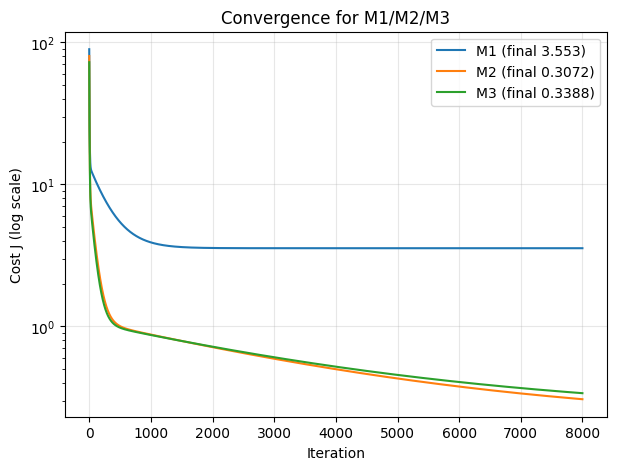

In [45]:
plt.figure(figsize=(7,5))
for d in trained:
    plt.plot(d['history'], label=f"{d['model']} (final {d['final_loss']:.4g})")
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Cost J (log scale)')
plt.title('Convergence for M1/M2/M3')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

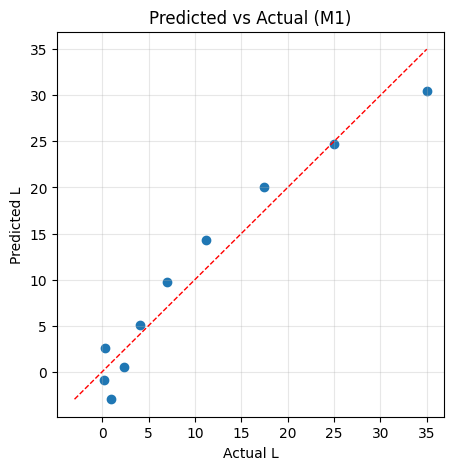

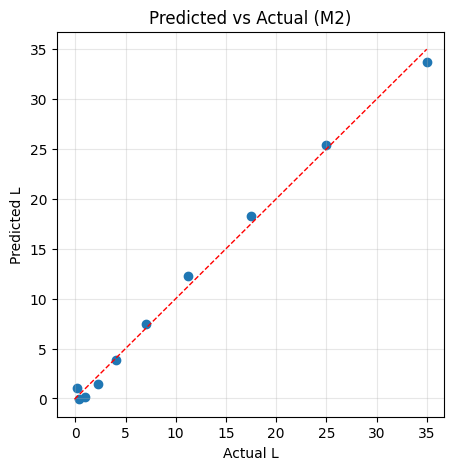

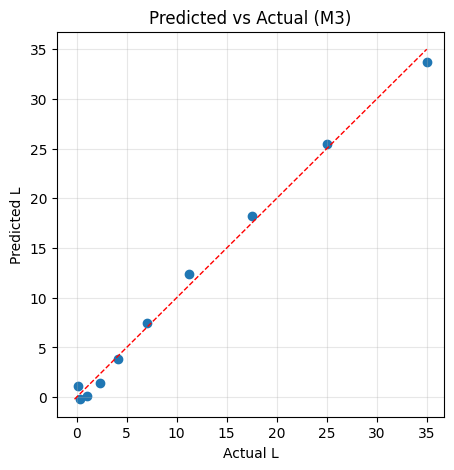

In [46]:
def plot_pred_vs_actual(d):
    yhat = predict_X(d['Xn'], d['w'], d['b'])
    plt.figure(figsize=(5,5))
    plt.scatter(L, yhat)
    lo = min(L.min(), yhat.min())
    hi = max(L.max(), yhat.max())
    plt.plot([lo, hi], [lo, hi], 'r--', linewidth=1)
    plt.xlabel('Actual L')
    plt.ylabel('Predicted L')
    plt.title(f"Predicted vs Actual ({d['model']})")
    plt.grid(True, alpha=0.3)
    plt.show()
    return yhat

_ = [plot_pred_vs_actual(d) for d in trained]

## 5) Cost vs interaction coefficient (mandatory)
For the full model (**M3**), we vary the interaction coefficient $w_{MT}$ while keeping the other parameters fixed (at their trained values).
If the cost curve has a clear minimum near the trained value, it suggests the interaction term matters for fitting this dataset.

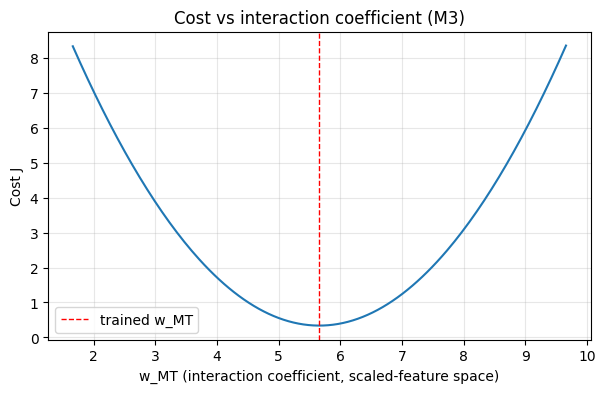

In [47]:
d3 = [d for d in trained if d['model'] == 'M3'][0]
w_tr = d3['w'].copy()
b_tr = d3['b']
Xn3 = d3['Xn']

w_mt_center = w_tr[-1]
w_mt_vals = np.linspace(w_mt_center - 4.0, w_mt_center + 4.0, 200)
costs = []
for v in w_mt_vals:
    w_tmp = w_tr.copy()
    w_tmp[-1] = v
    costs.append(cost_mse_half_X(Xn3, L, w_tmp, b_tr))
costs = np.array(costs)

plt.figure(figsize=(7,4))
plt.plot(w_mt_vals, costs)
plt.axvline(w_mt_center, color='r', linestyle='--', linewidth=1, label='trained w_MT')
plt.xlabel('w_MT (interaction coefficient, scaled-feature space)')
plt.ylabel('Cost J')
plt.title('Cost vs interaction coefficient (M3)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 6) Inference demo (mandatory)
Predict luminosity for a new star, e.g. $M=1.3$, $T=6600$ using the full model (M3).
We build its features, standardize them with the *training* mean/std, then compute $\hat{L}$.

In [48]:
M_new = 1.3
T_new = 6600.0

X_new = make_X(np.array([M_new]), np.array([T_new]), model='M3')
X_new_n = standardize_transform(X_new, d3['mu'], d3['sigma'])

L_pred = predict_X(X_new_n, d3['w'], d3['b']).item()

L_pred

2.475281378458715

**Reasonableness (brief):**
For $M=1.3$ (between 1.2 and 1.4 in the dataset), we expect luminosity between about 2.3 and 4.1. The model prediction should fall in that neighborhood; if it does, it is plausible for this toy dataset.